In [1]:
%pylab inline 
import geopandas as gpd 
import rasterio as rio 
import rasterio.mask as mask
import rasterio.features
import rasterio.plot as riop 
import shapely
from whitebox.whitebox_tools import WhiteboxTools


import os
from gis_functions import clip_raster_to_geometry, clip_shp_to_geometry
from sinkhole_functions import calc_karst_fraction

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [20]:
datadir = '/home/mcoving/github/sinkhole_analysis/PR/'

basedir = '/home/mcoving/Dropbox/sync/projects/Dolines/Puerto-Rico/'

PR_huc12 = gpd.read_file(basedir+'NHDPLUS_H_2101_HU4_GDB.gdb', layer='WBDHU12')

In [26]:
PR_huc12[PR_huc12.huc12 == '210100020210']

,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc12,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,shape_Length,shape_Area,geometry
92,{8102C20C-6A54-42FF-9989-DEDF597C55F4},NaN,NaN,NaN,NaN,2013-01-18 07:08:54+00:00,NaN,38962.05,157.67,PR,210100020210,Rio Grande de Manati,NaN,"KA,NC",210100020211,0.0,0.0,1.507192,0.013476,"MULTIPOLYGON (((-66.52622 18.45569, -66.52615 ..."


In [4]:
bbox = shapely.geometry.box(-66.660, 18.331,  -66.600, 18.357)

In [5]:
want_hucs = PR_huc12[PR_huc12.intersects(bbox)]

In [27]:
#this_huc = want_hucs.iloc[0]
#this_huc = want_hucs[want_hucs.huc12 == '210100020301']
this_huc = PR_huc12[PR_huc12.huc12 == '210100020210']

In [28]:
clipname='HUC-' + str(this_huc.huc12) + '-'
clipname

'HUC-92    210100020210\nName: huc12, dtype: object-'

In [33]:
os.chdir(datadir)
rasterdir = os.path.join(basedir,'HRNHDPlusRasters2101/')
rasterfile = 'elev_cm.tif'
img_elev = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=this_huc,
                              clipname='HUC-' + this_huc.huc12.array[0] + '-')
rasterfile = 'hydrodem.tif'
img_hyd = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=this_huc,
                              clipname='HUC-' + this_huc.huc12.array[0] + '-')


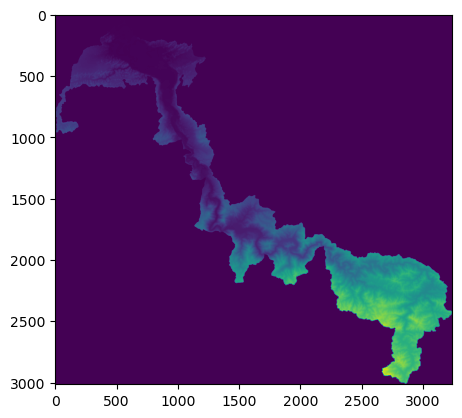

<Axes: >

In [38]:
riop.show(img_elev)

In [31]:
wbt = WhiteboxTools()

In [60]:
wbt.depth_in_sink(datadir + 'HUC-210100020210-elev_cm.tif', datadir + 'HUC-210100020210-depth.tif')

./whitebox_tools --run="DepthInSink" --dem='/home/mcoving/github/sinkhole_analysis/PR/HUC-210100020210-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/PR/HUC-210100020210-depth.tif' -v --compress_rasters=False

****************************
* Welcome to DepthInSink   *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Finding pit cells: 6%
Finding pit cells: 12%
Finding pit cells: 18%
Finding pit cells: 25%
Finding pit cells: 31%
Finding pit cells: 37%
Finding pit cells: 43%
Finding pit cells: 50%
Finding pit cells: 56%
Finding pit cells: 62%
Finding pit cells: 68%
Finding pit cells: 75%
Finding pit cells: 81%
Finding pit cells: 87%
Finding pit cells: 93%
Finding pit cells: 100%
Finding depressions: 0%
Finding depressions: 1%
Finding depressions: 2%
Finding depressions: 3%
Finding depressions: 4%
Finding depressions: 5%
Finding depressions: 6%
Finding depressions: 7%
Finding depressions: 8%
Finding depressions: 9%
Findin

0

In [70]:
depth_src = rio.open('./HUC-210100020210-depth.tif')
depth = depth_src.read()
sink_src = rio.open('./HUC-210100020210-elev_cm-sinks.tif')
sinks = sink_src.read()

In [71]:
ndv = sink_src.nodata
shallow_sinks = depth < 300
sinks[shallow_sinks] = ndv

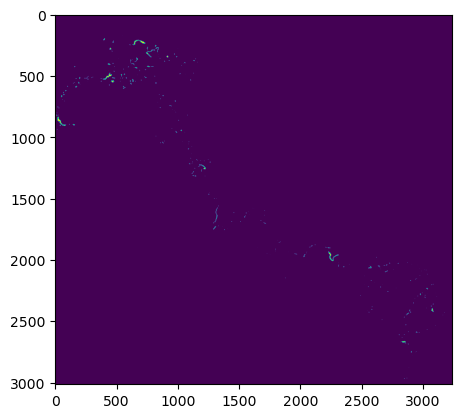

<Axes: >

In [72]:
riop.show(sinks)

In [73]:
profile = sink_src.profile
with rasterio.open('./HUC-210100020210-depth-filtered-sinks.tif', 'w', **profile) as dest:
    dest.write(sinks)

In [65]:
# wbt.sink('HUC-210100020210-hydrodem.tif', 'hydro-sinks.tif')

./whitebox_tools --run="Sink" --input='HUC-210100020210-hydrodem.tif' --output='hydro-sinks.tif' -v --compress_rasters=False

****************************
* Welcome to Sink          *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
thread 'main' panicked at 'No such file or directory (os error 2)', whitebox-tools-app/src/main.rs:72:21
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


0

In [13]:
# wbt.sink('./HUC-210100020301-elev_cm.tif', 'HUC-210100020301-sinks.tif')

In [74]:
# sinksfile = os.path.join(datadir,'HUC-210100020210-sinks.tif')
wat_elev = calc_karst_fraction(datadir=datadir,
                          sinksfile = datadir+'HUC-210100020210-elev_cm-depth-filtered-sinks.tif',
                          demfile='HUC-210100020210-elev_cm.tif',
                          mean_filter=False,
                          fill_pits=False)


./whitebox_tools --run="D8Pointer" --dem='/home/mcoving/github/sinkhole_analysis/PR/HUC-210100020210-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/PR/HUC-210100020210-elev_cm-d8.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progr

In [12]:
sinksfile = os.path.join(datadir,'HUC-210100020301-sinks.tif')
wat_elev = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-210100020301-elev_cm.tif',
                          mean_filter=False,
                          fill_pits=False)


./whitebox_tools --run="Sink" --input='/home/mcoving/github/sinkhole_analysis/PR/HUC-210100020301-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/PR/HUC-210100020301-elev_cm-sinks.tif' --zero_background -v --compress_rasters=False

****************************
* Welcome to Sink          *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Finding pit cells: 6%
Finding pit cells: 12%
Finding pit cells: 18%
Finding pit cells: 25%
Finding pit cells: 31%
Finding pit cells: 37%
Finding pit cells: 43%
Finding pit cells: 50%
Finding pit cells: 56%
Finding pit cells: 62%
Finding pit cells: 68%
Finding pit cells: 75%
Finding pit cells: 81%
Finding pit cells: 87%
Finding pit cells: 93%
Finding pit cells: 100%
Finding depressions: 0%
Finding depressions: 1%
Finding depressions: 2%
Finding depressions: 3%
Finding depressions: 4%
Finding depressions: 5%
Finding depressions: 6%
Finding depressions: 7%
Finding depressions: 8%
Finding d

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Initializing: 0%
Initializing: 1%
Initializing: 2%
Initializing: 3%
Initializing: 4%
Initializing: 5%
Initializing: 6%
Initializing: 7%
Initializing: 8%
Initializing: 9%
Initializing: 10%
Initializing: 11%
Initializing: 12%
Initializing: 13%
Initializing: 14%
Initializing: 15%
Initializing: 16%
Initializing: 17%
Initializing: 18%
Initializing: 19%
Initializing: 20%
Initializing: 21%
Initializing: 22%
Initializing: 23%
Initializing: 24%
Initializing: 25%
Initializing: 26%
Initializing: 27%
Initializing: 28%
Initializing: 29%
Initializing: 30%
Initializing: 31%
Initializing: 32%
Initializing: 33%
Initializing: 34%
Initializing: 35%
Initializing: 36%
Initializing: 37%
Initializing: 38%
Initializing: 39%
Initializing: 40%
Initializing: 41%
Initializing: 42%
Initializing: 43%
Initializing: 44%
Initializing: 45%
Initializing: 46%
Ini

<Axes: >

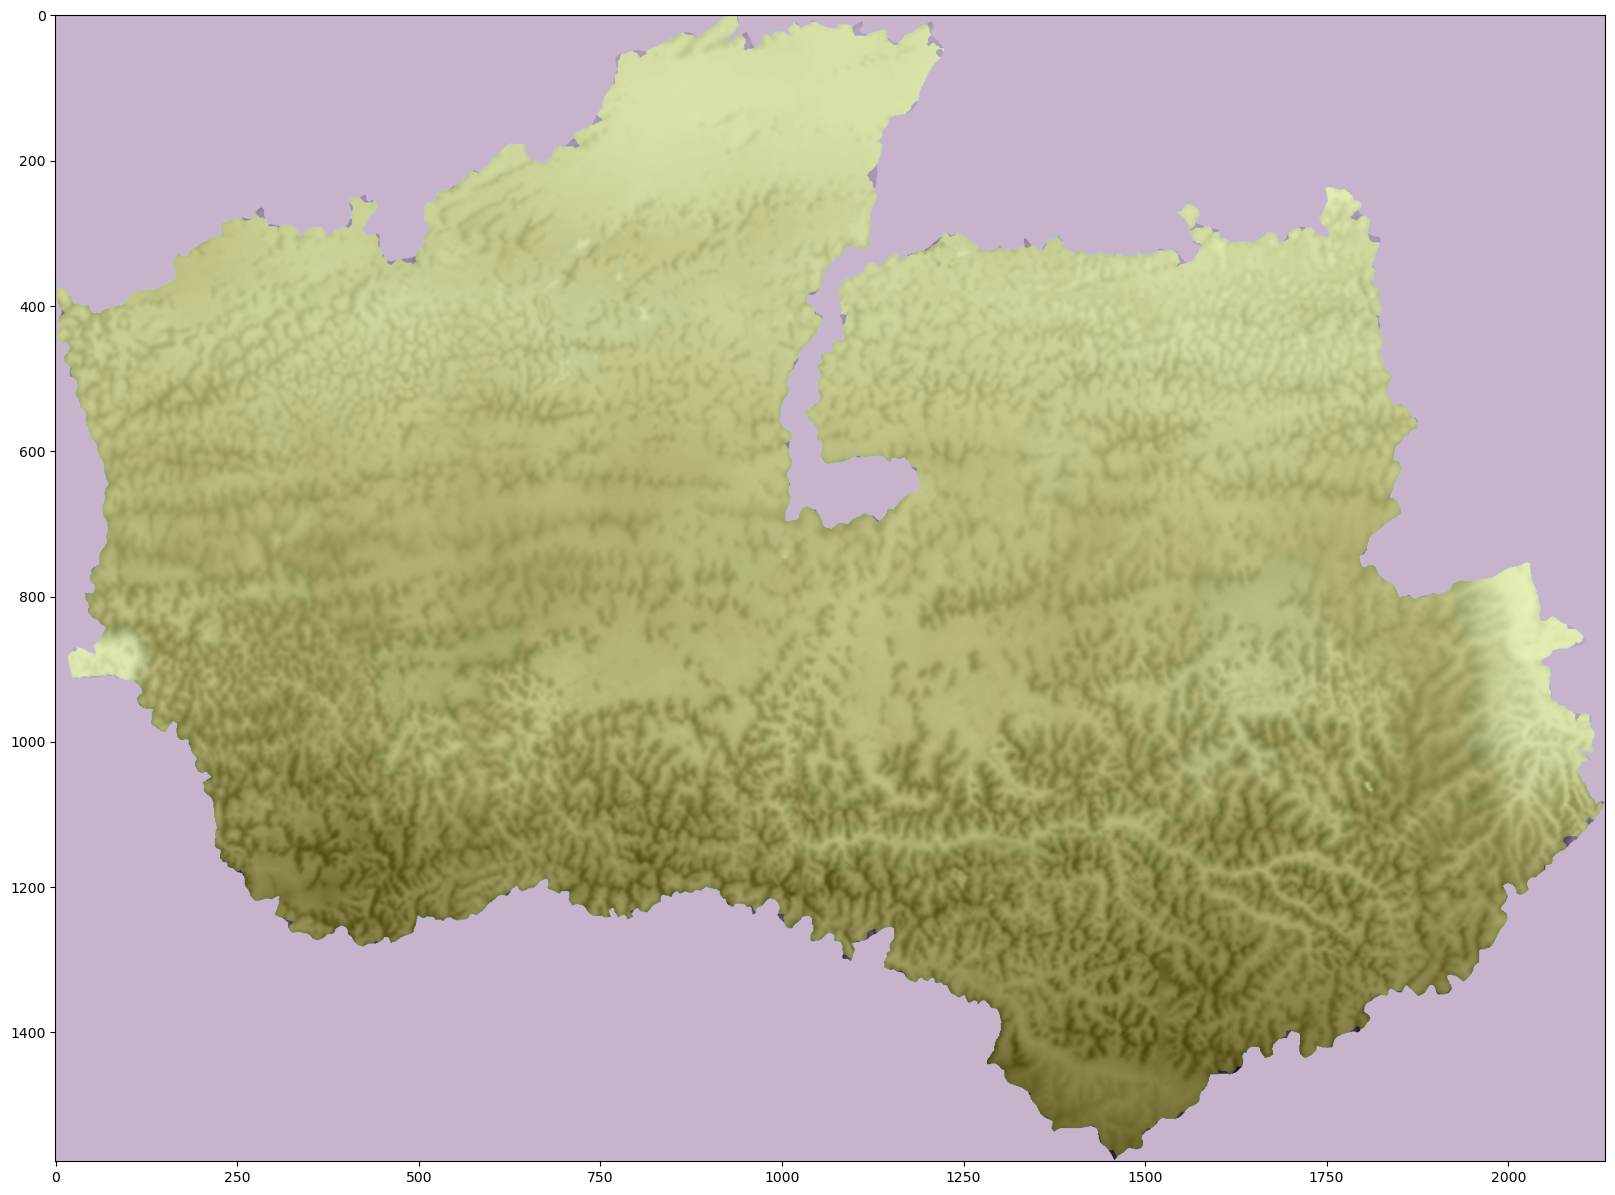

In [17]:
fig, ax = subplots(figsize=(20,20))
riop.show(img_elev, ax=ax, cmap='Greys')
riop.show(wat_elev, ax=ax, alpha=0.3)

In [46]:

ndv = wat_src.nodata
size(wat_elev[wat_elev!=ndv])


1982443

In [45]:
size(wat_elev[0])

3367452

In [29]:
wat_src = rio.open('./HUC-210100020301-elev_cm-wat.tif')

In [30]:
wat_src.get_nodatavals()

(-32768.0,)

In [27]:
wat_neg = wat_elev[wat_elev < 0]
for ndv in wat_src.get_nodatavals():
    wat_

array([-32768, -32768, -32768, ..., -32768, -32768, -32768], dtype=int32)

In [29]:
for huc in want_hucs:
    print((huc))

tnmid
metasourceid
sourcedatadesc
sourceoriginator
sourcefeatureid
loaddate
referencegnis_ids
areaacres
areasqkm
states
huc12
name
hutype
humod
tohuc
noncontributingareaacres
noncontributingareasqkm
shape_Length
shape_Area
geometry


In [30]:
want_hucs

,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc12,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,shape_Length,shape_Area,geometry
29,{FE03F989-12E4-41A6-941B-298AF2758DC7},None,None,None,None,2013-01-18 07:08:54+00:00,None,49107.46,198.73,PR,210100020301,Non-contributing area-Name not assigned,None,"KA,NC",CLOSED BASIN,49105.87467,198.7246,0.957397,0.016989,"MULTIPOLYGON (((-66.56338 18.43619, -66.56346 ..."
94,{7856F4E3-8D77-4B56-9DA3-9715B102FFD1},None,None,None,None,2013-01-18 07:08:54+00:00,None,12725.48,51.50,PR,210100020410,Rio Limon,None,KA,210100020411,0.00000,0.0000,0.359609,0.004400,"MULTIPOLYGON (((-66.61011 18.32935, -66.61028 ..."
95,{6440D1E7-C393-4ABA-90D2-A77C88370891},{5F3A5C33-7C94-4A21-8000-980A11DD6B86},None,None,None,2016-07-25 23:26:57+00:00,None,12862.87,52.05,PR,210100020414,Rio Grande de Arecibo at mouth,None,KA,210100020600,0.00000,0.0000,0.617576,0.004451,"MULTIPOLYGON (((-66.71080 18.47259, -66.71061 ..."
173,{ACDF75F6-010B-4C1E-99BA-3AC761B13D4A},None,None,None,None,2013-01-18 07:08:54+00:00,None,4466.32,18.07,PR,210100020411,Rio Caonillas,None,"IT,PD",210100020412,0.00000,0.0000,0.201805,0.001545,"MULTIPOLYGON (((-66.65755 18.33533, -66.65744 ..."
